# One Shot Learning with Siamese Networks

This is the jupyter notebook that accompanies

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

## Configuration Class
A simple class to manage configuration

In [3]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 100

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        while True:
            #keep looping till the same class image is found
            img1_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1]==img1_tuple[1]:
                break

        while True:
            #keep looping till a different class image is found
            
            img2_tuple = random.choice(self.imageFolderDataset.imgs) 
            if img0_tuple[1] !=img2_tuple[1]:
                break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img2 = Image.open(img2_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        img2 = img2.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
            img2 = PIL.ImageOps.invert(img2)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img0, img1, img2
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
print(len(siamese_dataset))
len_valid = 37*0
len_train = len(siamese_dataset) - len_valid
siamese_dataset, test_dataset = torch.utils.data.random_split(siamese_dataset, [len_train, len_valid])

370


## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

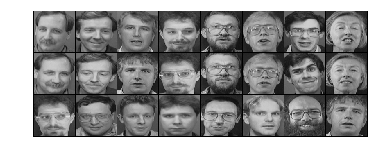

In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
concatenated = torch.cat((concatenated,example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated))

## Neural Net Definition
We will use a standard convolutional neural network

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3

## Training Time!

In [9]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [10]:
net = SiameseNetwork().cuda()
criterion = torch.nn.TripletMarginLoss(margin=2.0,p=2)
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [11]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 1.9760570526123047

Epoch number 1
 Current loss 0.20188213884830475

Epoch number 2
 Current loss 0.8885836005210876

Epoch number 3
 Current loss 0.2169375717639923

Epoch number 4
 Current loss 0.024289488792419434

Epoch number 5
 Current loss 0.2693146765232086

Epoch number 6
 Current loss 0.0

Epoch number 7
 Current loss 0.0

Epoch number 8
 Current loss 0.28175562620162964

Epoch number 9
 Current loss 0.3968459665775299

Epoch number 10
 Current loss 0.0

Epoch number 11
 Current loss 0.0

Epoch number 12
 Current loss 0.5303159952163696

Epoch number 13
 Current loss 0.22767633199691772

Epoch number 14
 Current loss 0.28010064363479614

Epoch number 15
 Current loss 0.4042849838733673

Epoch number 16
 Current loss 0.0

Epoch number 17
 Current loss 0.0

Epoch number 18
 Current loss 0.0

Epoch number 19
 Current loss 0.1590598225593567

Epoch number 20
 Current loss 0.09468108415603638

Epoch number 21
 Current loss 0.0

Epoch number 22
 Curren

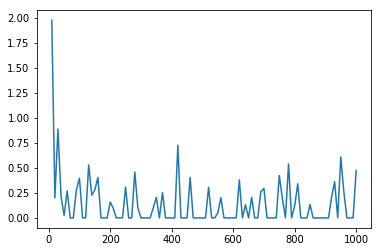

In [12]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1, img2 = data
        img0, img1, img2 = img0.cuda(), img1.cuda(), img2.cuda()
        optimizer.zero_grad()
        output1,output2,output3 = net(img0,img1,img2)
        loss_triplet = criterion(output1,output2,output3)
        loss_triplet.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_triplet.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_triplet.item())
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

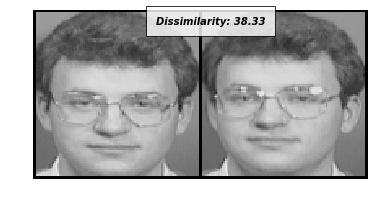

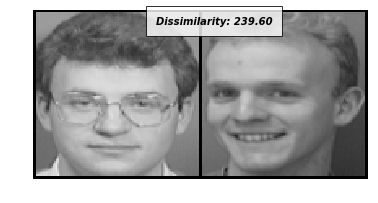

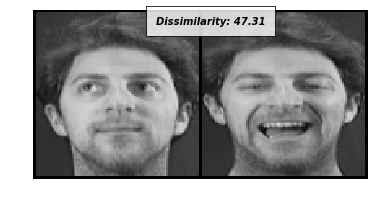

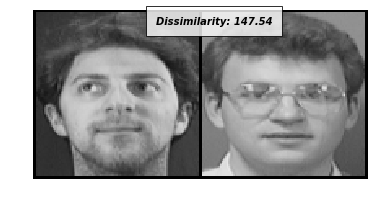

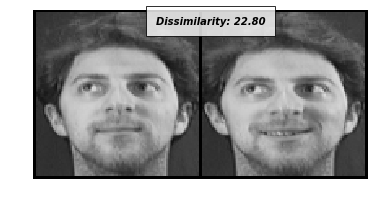

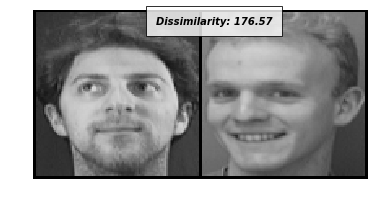

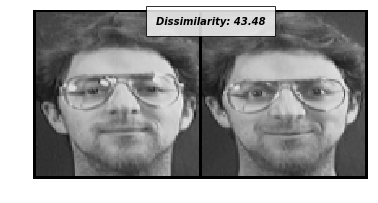

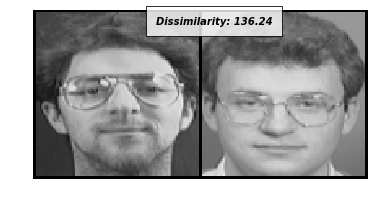

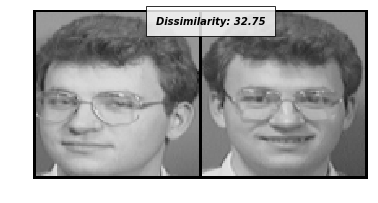

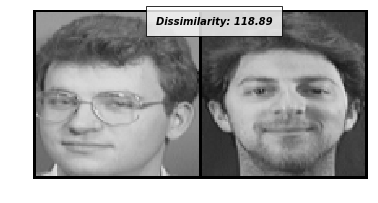

In [13]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)

for i in range(5):
    x0,x1,x2 = next(dataiter)
    concatenated_ap = torch.cat((x0,x1),0)
    concatenated_an = torch.cat((x0,x2),0)
    
    output1,output2,output3 = net(Variable(x0).cuda(),Variable(x1).cuda(),Variable(x2).cuda())
    euclidean_distance_ap = F.pairwise_distance(output1, output2)
    euclidean_distance_an = F.pairwise_distance(output1, output3)
    imshow(torchvision.utils.make_grid(concatenated_ap),'Dissimilarity: {:.2f}'.format(euclidean_distance_ap.item()))
    imshow(torchvision.utils.make_grid(concatenated_an),'Dissimilarity: {:.2f}'.format(euclidean_distance_an.item()))



In [14]:
dataiter = iter(test_dataloader)

correct = 0
total = 0
threshold = 130

ap_dist_list = []
an_dist_list = []

with torch.no_grad():
    for x0,x1,x2 in dataiter:        
        output1,output2,output3 = net(Variable(x0).cuda(),Variable(x1).cuda(),Variable(x2).cuda())
        euclidean_distance_ap = F.pairwise_distance(output1, output2)
        euclidean_distance_an = F.pairwise_distance(output1, output3)
        ap_dist_list.append(euclidean_distance_ap.item())
        an_dist_list.append(euclidean_distance_an.item())
        if euclidean_distance_ap.item() <= threshold:
            correct += 1
        if euclidean_distance_an.item() > threshold:
            correct += 1
        total += 2
    # correct += sum([i<=threshold for i in ap_dist_list])
    # correct += sum([i>threshold for i in an_dist_list])

print('Max euclidean distance for anchor and positive: ', max(ap_dist_list))
print('Min euclidean distance for anchor and negative: ', min(an_dist_list))
print('Average euclidean distance for anchor and positive: %.2f, %.2f' % (np.mean(ap_dist_list), np.std(ap_dist_list)))
print('Average euclidean distance for anchor and negative: %.2f, %.2f' % (np.mean(an_dist_list), np.std(an_dist_list)))
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Max euclidean distance for anchor and positive:  84.52616882324219
Min euclidean distance for anchor and negative:  93.7510757446289
Average euclidean distance for anchor and positive: 32.44, 19.71
Average euclidean distance for anchor and negative: 171.13, 50.74
Accuracy of the network on the test images: 90 %


In [15]:
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)

@torch.no_grad()
def get_margin(net):
    max_ap_dist = -np.inf
    min_an_dist = np.inf

    dataiter = iter(test_dataloader)

    for x0,x1,x2 in dataiter:        
        output1,output2,output3 = net(Variable(x0).cuda(),Variable(x1).cuda(),Variable(x2).cuda())
        euclidean_distance_ap = F.pairwise_distance(output1, output2)
        euclidean_distance_an = F.pairwise_distance(output1, output3)
        if euclidean_distance_ap.item() >= max_ap_dist:
            max_ap_dist = euclidean_distance_ap.item() 
        if euclidean_distance_an.item() < min_an_dist:
            min_an_dist = euclidean_distance_an.item() 
    return max_ap_dist, min_an_dist

def get_normalized_margin(net):
    ap_dist_list = []
    an_dist_list = []

    for i in range(50):
        max_ap_dist, min_an_dist = get_margin(net)
        ap_dist_list.append(max_ap_dist)
        an_dist_list.append(min_an_dist)
    print('Anchor and postivie average maximum distance is ', np.mean(ap_dist_list))
    print('Anchor and negative average maximum distance is ', np.mean(an_dist_list))
    print('Normalized margin %.2f %%' % (100*(1 - np.mean(ap_dist_list)/np.mean(an_dist_list))))

get_normalized_margin(net)

Anchor and postivie average maximum distance is  85.31850852966309
Anchor and negative average maximum distance is  99.9259080505371
Normalized margin 14.62 %
